<a href="https://colab.research.google.com/github/AleksanderDanilian/CardioSpike/blob/main/%D0%9F%D1%80%D0%BE%D1%82%D0%B0%D0%B3%D0%BE%D0%BD%D0%B8%D1%81%D1%82%D1%8B_%22CardioSpike_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, \
concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Conv1D, MaxPooling1D, Lambda
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных
from sklearn.metrics import f1_score

import warnings
import random
import os #
from google.colab import drive #модуль для работы с google диском 
import time
import random
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dfBase = pd.read_csv('/content/train.csv')

In [ ]:
df = dfBase.copy()

In [ ]:
df = df[:55084] # остальное на тест

In [ ]:
cvdDf = df[df['y']==1]

In [ ]:
# получим списки значений x для ковид участков и индексы DataFrame им соответсвующие

cvdLst = []
idxLst = []
cases = 275

for j in range(cases):
  cvdLst.append(cvdDf[cvdDf['id']==j]['x'].values)
  idxLst.append(cvdDf[cvdDf['id']==j].index.values)
  

In [ ]:
# соберем все сигналы ковида по отдельным массивам
cvdLstSp = [] #CovidListSeparate
cvdIndSp = [] #Indexes separate

for i in range(cases):
  temp = []
  tCount = 0
  for j in range(len(idxLst[i])-1):
    if idxLst[i][j+1] > idxLst[i][j] + 1:
      cvdLstSp.append(cvdLst[i][tCount:j+1])
      cvdIndSp.append(idxLst[i][tCount:j+1])
      tCount = j+1
    if j == (len(idxLst[i])-2):
      cvdLstSp.append(cvdLst[i][tCount:j+2])
      cvdIndSp.append(idxLst[i][tCount:j+2])


In [ ]:
# напишем ф-цию, которая будет увеличивать "ковид-интервалы" до требуемой длины окна.

def getCvdIntervals(window = 41, cvdIndSp = cvdIndSp, df = df):

  cvdLstOSidxs = [] #covid List One Size indexes

  for i in range(len(cvdIndSp)):
    
    length = len(cvdIndSp[i])
    if length < window:
      increase = window - length
      if increase % 2 == 0:
        temp = [i for i in range(min(cvdIndSp[i]) - int((window - length)/2), max(cvdIndSp[i]) + int((window - length)/2) + 1)]
      if increase % 2 == 1:
        temp = [i for i in range(min(cvdIndSp[i]) - int((window - length)/2), max(cvdIndSp[i]) + int((window - length)/2) + 2)]
    
    elif length > window:
      decrease = length - window
      if decrease % 2 == 0:
        temp = [i for i in range(min(cvdIndSp[i]) + int((length - window)/2), max(cvdIndSp[i]) - int((length - window)/2) + 1 )]
      if decrease % 2 == 1:
        temp = [i for i in range(min(cvdIndSp[i]) + int((length - window)/2), max(cvdIndSp[i]) - int((length - window)/2) )]

    else:
      temp = cvdIndSp[i]   # window == length

    
    cvdLstOSidxs.append(temp)
    
  cvdLstOSrr = [] # covid List One Size RR intervals

  
  for i in range(len(cvdLstOSidxs)):
    
      cvdLstOSrr.append(df.iloc[cvdLstOSidxs[i],2].values)

  return cvdLstOSrr, cvdLstOSidxs

In [ ]:
def getNrmlIntervals(window = 6, df = df, idxs = idxLst, step=10, cases = 237):
  # idxLst - список ковидных аномалий (индексы из базы df)
  # step - шаг нарезки данных. Уменьшить шаг - больше данных.
  # window - ширина окна данных

  xVals = []
  idxs = []
  cases = cases

  for j in range(cases):
    xVals.append(df[df['id']==j]['x'].values)
    idxs.append(df[df['id']==j].index.values)

  nrmlIntervals = []
  for i in range(cases):
    temp = []
    
    for k in range(len(xVals[i])):
      if all(idxLst[i]!=idxs[i][k]) and len(xVals[i])!=0:   #если индекс не равен любому из списка ковидных
        temp.append(xVals[i][k])
        
      else:
        
        for z in range(0,len(temp) - window, step):
          z2 = z + window
          if len(temp[z:z2])==window:
            nrmlIntervals.append(temp[z:z2])
        temp = []

  return nrmlIntervals


In [ ]:
# сформируем y

def getY(nrmLst = [], cvdLst = []):

  y = [0 for el in nrmLst]
  y1 = [1 for el in cvdLst]
  y.extend(y1)
  y = np.array(y)

  return y


In [ ]:
# сформируем x

def getX(nrmLst = [], cvdLst = []):
  x = []
  x.extend(nrmLst)
  x.extend(cvdLst)

  return x


In [ ]:
def augm(x, window):
  b = 1.03
  a = 0.97
  x = x*((b - a) * np.random.random_sample(window) + a)
  return x

In [ ]:
# Ф-ция подготовки данных

def getXY(window = 8, df = df, idxs = idxLst, cvdIndSp = cvdIndSp, step=85, test_size = 0.2, Conv = False):

  cvdLst,_ = getCvdIntervals(window = window, cvdIndSp=cvdIndSp, df = df)
  nrmLst = getNrmlIntervals(window = window, df = df, idxs = idxs, step = step)

  for i in range(len(cvdLst)):
    for j in range(15):
      temp = augm(cvdLst[i], window=window)
      cvdLst.append(temp)
  
  for i in range(len(nrmLst)):
    for j in range(10):
      temp = augm(nrmLst[i], window = window)
      nrmLst.append(temp)


  Y = getY(nrmLst = nrmLst, cvdLst = cvdLst)
  X = getX(nrmLst = nrmLst, cvdLst = cvdLst)

  X = np.array(X)
  Y = np.array(Y)

  scaler = StandardScaler()
  X = scaler.fit_transform(X)  

  if Conv:
    X = X.reshape((X.shape[0],X.shape[1],1))

  print(X.shape, Y.shape)

  x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = test_size, shuffle = True)  

  return x_train, x_val, y_train, y_val, scaler

In [ ]:
#ДАННЫЕ ДЛЯ 1 МОДЕЛИ (scaler8 - окно 8, шаг влияет на вел-ну выборки)

window = 8 
step = 3

x_train1, x_val1, y_train1, y_val1, scaler8 = getXY(Conv = True, window = window, test_size=0.02, step = step)


(125411, 8, 1) (125411,)


In [ ]:
model1 = Sequential()

model1.add(Conv1D(256, 5, padding = 'same', activation = 'linear'))
model1.add(Conv1D(128, 5, padding = 'same', activation = 'linear'))

#model1.add(MaxPooling1D())
model1.add(Conv1D(128, 5, padding = 'same', activation = 'linear'))
model1.add(Conv1D(64, 5, padding = 'same', activation = 'linear'))

model1.add(Flatten())

model1.add(Dense(2000, activation = 'sigmoid'))
model1.add(Dense(750, activation = 'sigmoid'))

model1.add(Dense(1, activation = 'sigmoid'))

model1.compile(loss = 'binary_crossentropy', optimizer = Adam(0.001), metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0000001)

model1.fit(x_train1, y_train1, batch_size = 128, epochs = 100, validation_data = (x_val1, y_val1), callbacks=[reduce_lr])

Epoch 1/100
961/961 [==============================] - 5s 5ms/step - loss: 0.2359 - accuracy: 0.9174 - val_loss: 0.1919 - val_accuracy: 0.9259
Epoch 2/100
961/961 [==============================] - 4s 5ms/step - loss: 0.1506 - accuracy: 0.9427 - val_loss: 0.1143 - val_accuracy: 0.9570
Epoch 3/100
961/961 [==============================] - 5s 5ms/step - loss: 0.1353 - accuracy: 0.9477 - val_loss: 0.1126 - val_accuracy: 0.9562
Epoch 4/100
961/961 [==============================] - 5s 5ms/step - loss: 0.1339 - accuracy: 0.9476 - val_loss: 0.1319 - val_accuracy: 0.9506
Epoch 5/100
961/961 [==============================] - 5s 5ms/step - loss: 0.1358 - accuracy: 0.9478 - val_loss: 0.1393 - val_accuracy: 0.9438
Epoch 6/100
961/961 [==============================] - 5s 5ms/step - loss: 0.1264 - accuracy: 0.9516 - val_loss: 0.1147 - val_accuracy: 0.9534
Epoch 7/100
961/961 [==============================] - 4s 5ms/step - loss: 0.1267 - accuracy: 0.9508 - val_loss: 0.1159 - val_accuracy: 0.9562

In [ ]:
#ДАННЫЕ ДЛЯ 2 МОДЕЛИ (scaler10 - окно 10, шаг влияет на вел-ну выборки)

window = 10 
step = 3

x_train2, x_val2, y_train2, y_val2, scaler10 = getXY(Conv = True, window = window, test_size=0.02, step = step)

In [ ]:

model2 = Sequential()

model2.add(Conv1D(256, 5, padding = 'same', activation = 'elu'))
model2.add(Conv1D(128, 5, padding = 'same', activation = 'elu'))

#model2.add(MaxPooling1D())
model2.add(Conv1D(128, 5, padding = 'same', activation = 'elu'))
model2.add(Conv1D(32, 5, padding = 'same', activation = 'elu'))

model2.add(Flatten())

model2.add(Dense(2000, activation = 'sigmoid'))
model2.add(Dense(750, activation = 'sigmoid'))

model2.add(Dense(1, activation = 'sigmoid'))

model2.compile(loss = 'binary_crossentropy', optimizer = Adam(0.001), metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0000001)

model2.fit(x_train2, y_train2, batch_size = 128, epochs = 100, validation_data = (x_val2, y_val2), callbacks=[reduce_lr])

Epoch 1/100
758/758 [==============================] - 5s 5ms/step - loss: 0.1834 - accuracy: 0.9330 - val_loss: 0.1270 - val_accuracy: 0.9525
Epoch 2/100
758/758 [==============================] - 4s 5ms/step - loss: 0.1216 - accuracy: 0.9526 - val_loss: 0.1254 - val_accuracy: 0.9515
Epoch 3/100
758/758 [==============================] - 4s 5ms/step - loss: 0.1163 - accuracy: 0.9550 - val_loss: 0.1153 - val_accuracy: 0.9581
Epoch 4/100
758/758 [==============================] - 4s 5ms/step - loss: 0.1122 - accuracy: 0.9572 - val_loss: 0.1175 - val_accuracy: 0.9576
Epoch 5/100
758/758 [==============================] - 4s 5ms/step - loss: 0.1091 - accuracy: 0.9578 - val_loss: 0.1141 - val_accuracy: 0.9596
Epoch 6/100
758/758 [==============================] - 4s 5ms/step - loss: 0.1055 - accuracy: 0.9596 - val_loss: 0.1051 - val_accuracy: 0.9611
Epoch 7/100
758/758 [==============================] - 4s 5ms/step - loss: 0.1013 - accuracy: 0.9606 - val_loss: 0.1111 - val_accuracy: 0.9606

In [ ]:
# ф-ция для заполнения файла

pathIn = '/content/test.csv' ## будет другое имя файла
pathOut = '/content/submission.csv'

dfTst = pd.read_csv(pathIn)

In [ ]:
# ф-ция подготовки файла к отправке на проверку

def check(df = dfTst, threshold = 3.0, window1 = 10, window2 = 8, scaler1 = scaler10, scaler2 = scaler8):

  totalScore = []
  totalTrueVals = []
  totalResultCum = []
  idLst = df['id'].unique()
  for i in idLst:
    tempX = []
    tempIdxs = []
    testLstX1 = []
    testLstIdx1 = []
    testLstX2 = []
    testLstIdx2 = []
    
    tempX.extend(df[df['id']==i]['x'].values) # формируем данные для подачи в нс
    tempIdxs.extend(df[df['id']==i].index.values)

    for j in range(0,len(tempX)-window1+1, 1):
      
      t = scaler1.transform([tempX[j:j + window1]]) 
      testLstX1.append(t)
      testLstIdx1.append(tempIdxs[j:j + window1])

    resultCum = [0.0 for el in range(len(tempX))]
    for k in range(len(testLstX1)): # для каждого из окон (8 значений со смещением 1)
      if len(testLstX1[k])!=0:
        testLstX1[k] = testLstX1[k].reshape((testLstX1[k].shape[0],testLstX1[k].shape[1],1))
        result1 = model1.predict(testLstX1[k])[0][0] # получаем предикты по окнам из 8 значений для одного кейса за раз.
        
        resultWindowSpread1 = np.concatenate([[0.0 for i in range(k)],[result1 for i in range(window1)],[0.0 for i in range(k+window1,len(tempX))]])
        
        resultCum = resultCum + resultWindowSpread1 

    for j in range(0,len(tempX)-window2+1, 1):
      
      t = scaler2.transform([tempX[j:j + window2]]) 
      testLstX2.append(t)
      testLstIdx2.append(tempIdxs[j:j+window2])

    for k in range(len(testLstX2)): # для каждого из окон (8 значений со смещением 1)
      if len(testLstX2[k])!=0:
        testLstX2[k] = testLstX2[k].reshape((testLstX2[k].shape[0],testLstX2[k].shape[1],1))
        
        result2 = model2.predict(testLstX2[k])[0][0] # 2я модель с другим окном
       
        resultWindowSpread2 = np.concatenate([[0.0 for i in range(k)],[result2 for i in range(window2)],[0.0 for i in range(k+window2,len(tempX))]])
        resultCum = resultCum + resultWindowSpread2


    if len(resultCum)!=0: ## 0 тоже надо вставить
        totalResultCum.extend(resultCum)
    
  res1_0 = [1 if x>threshold else 0 for x in totalResultCum]  

  temp = []
  for z in range(len(pr1)):
    
    if pr1[z]==1:
      temp.append(z)
    elif pr1[z]==0:
      dl = len(temp)
      temp = []
      if dl > 0 and dl < 4:
        pr1[z-dl:z]=[0 for el in range(dl)]  #убираем 1, если их мало(маленькое окно)

  return res1_0
  

In [ ]:
res = check()

In [ ]:
dfTst['y']=res
dfTst.to_csv('submission874.csv')

In [ ]:
# ф-ция для определения индекса, в котором будет 1

def resCaseCalc(x):
  # свыше значения в 1.5 - записываем в "правильные ответы"
  if x > threshold:
    return 1.0
  else:
    return 0.0

In [ ]:
# вариация с 2мя моделями/окнами
def countF1(threshold = 5.02, window1 = 10, window2 = 8, scaler1 = scaler10, scaler2 = scaler8):

  totalScore = []
  totalTrueVals = []
  totalResultCum = []
  for i in range(237,275): #275
    tempX = []
    tempIdxs = []
    testLstX1 = []
    testLstIdx1 = []
    testLstX2 = []
    testLstIdx2 = []
    tempX.extend(dfBase[55084:][dfBase['id']==i]['x'].values) # формируем данные для подачи в нс
    tempIdxs.extend(dfBase[55084:][dfBase['id']==i].index.values)

    for j in range(0,len(tempX)-window1+1, 1):
      
      t = scaler1.transform([tempX[j:j + window1]]) 
      testLstX1.append(t)
      testLstIdx1.append(tempIdxs[j:j+window1])

    trueVals = dfBase[dfBase['id']==i]['y'].values # все реальные значения в этом кейсе
    trueValsIndx = dfBase[dfBase['id']==i]['y'].index.values

    resultCum = [0.0 for el in range(len(trueVals))]
    for k in range(len(testLstX1)): # для каждого из окон (8 значений со смещением 1)
      if len(testLstX1[k])!=0:
        testLstX1[k] = testLstX1[k].reshape((testLstX1[k].shape[0],testLstX1[k].shape[1],1))
        result1 = model1.predict(testLstX1[k])[0][0] # получаем предикты по окнам из 8 значений для одного кейса за раз.
        
        resultWindowSpread1 = np.concatenate([[0.0 for i in range(k)],[result1 for i in range(window1)],[0.0 for i in range(k+window1,len(trueVals))]])
        
        resultCum = resultCum + resultWindowSpread1 

    for j in range(0,len(tempX)-window2+1, 1):
      
      t = scaler2.transform([tempX[j:j + window2]]) 
      testLstX2.append(t)
      testLstIdx2.append(tempIdxs[j:j+window2])

    for k in range(len(testLstX2)): # для каждого из окон (8 значений со смещением 1)
      if len(testLstX2[k])!=0:
        testLstX2[k] = testLstX2[k].reshape((testLstX2[k].shape[0],testLstX2[k].shape[1],1))
        
        result2 = model2.predict(testLstX2[k])[0][0] # 2я модель с другим окном
       
        resultWindowSpread2 = np.concatenate([[0.0 for i in range(k)],[result2 for i in range(window2)],[0.0 for i in range(k+window2,len(trueVals))]])
        resultCum = resultCum + resultWindowSpread2

    totalTrueVals.append(trueVals)
    totalResultCum.append(resultCum)
    #resCase = list(map(resCaseCalc, resultCum))
    
    #score = f1_score(trueVals, resCase, average='binary')
     
    #totalScore.append(score)

  return totalTrueVals, totalResultCum #, totalScore
  

In [ ]:
# Поиск значений totalTrueVals, totalResultCum для определения threshold

threshold = 6
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    totalTrueVals, totalResultCum = countF1(threshold = threshold, window1 = 11, window2 = 7, scaler1 = scaler11, scaler2 = scaler7)

In [ ]:
# посчитаем общую точность и найдем оптимальный threshold

tr=[]
pr=[]

for i in range(len(totalTrueVals)):
  tr.extend(totalTrueVals[i])
  pr.extend(totalResultCum[i])

thresholdVals = [i/100 for i in range(100, 750, 1)]
for i in range(len(thresholdVals)):

  pr1 = [1 if x>thresholdVals[i] else 0 for x in pr]

  print(f1_score(tr, pr1), thresholdVals[i])


0.7443408788282291 1.0
0.7468269873079493 1.01
0.7476572958500669 1.02
0.7494129486749412 1.03
0.7506720430107527 1.04
0.7534569983136593 1.05
0.7562626946513202 1.06
0.7572881355932204 1.07
0.7585738539898131 1.08
0.7582454947296837 1.09
0.7592781750085119 1.1
0.7604095563139932 1.11
0.7611889306457124 1.12
0.7615463564830653 1.13
0.7620677850051353 1.14
0.763374485596708 1.15
0.7654745529573591 1.16
0.7667929727867723 1.17
0.7689119170984456 1.18
0.7694434842723816 1.19
0.7700831024930748 1.2
0.7714186611168922 1.21
0.7715277777777777 1.22
0.7721739130434783 1.23
0.7737887765772046 1.24
0.7745987438939288 1.25
0.7755244755244756 1.26
0.779887482419128 1.27
0.7804363124560169 1.28
0.7815362931642001 1.29
0.7826393789696542 1.3
0.7829156371337804 1.31
0.7842998585572843 1.32
0.7849805171803047 1.33
0.7855370436015597 1.34
0.7858156028368796 1.35
0.7853848882582476 1.36
0.7856635911994323 1.37
0.7862215909090908 1.38
0.7879003558718862 1.39
0.7887424296401851 1.4
0.7909967845659164 1.41

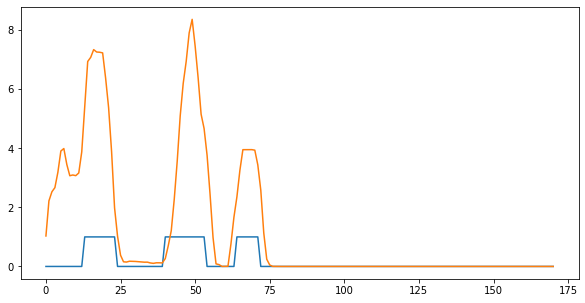

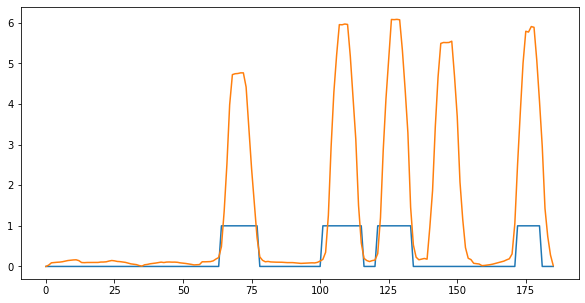

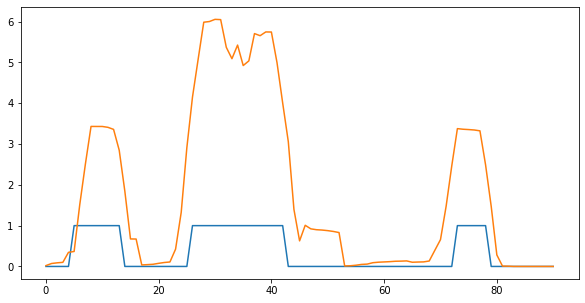

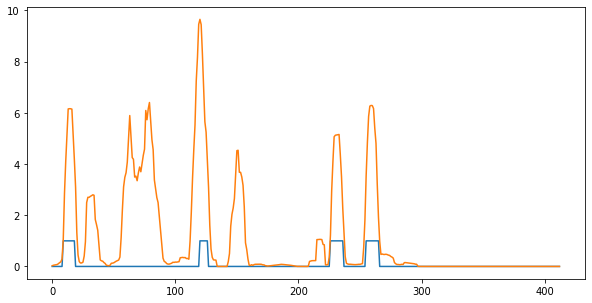

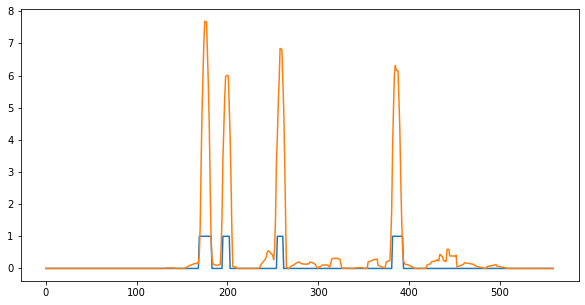

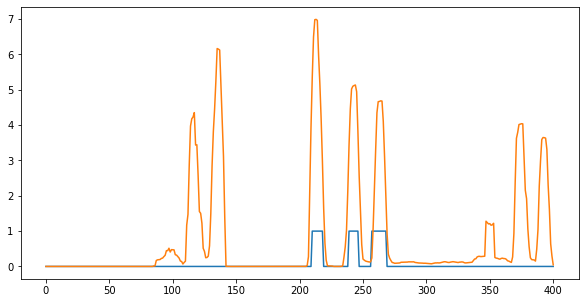

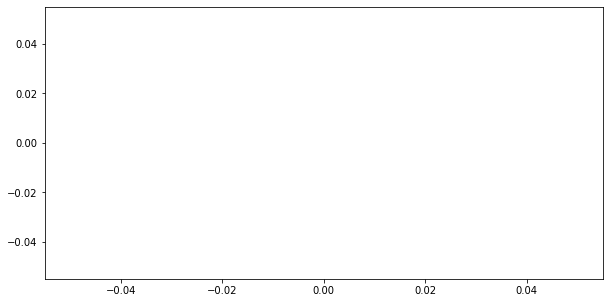

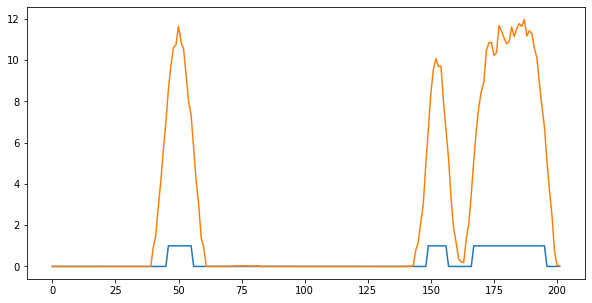

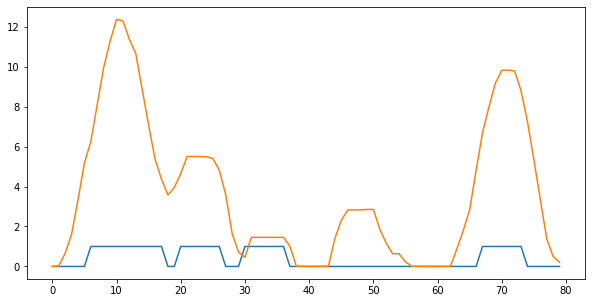

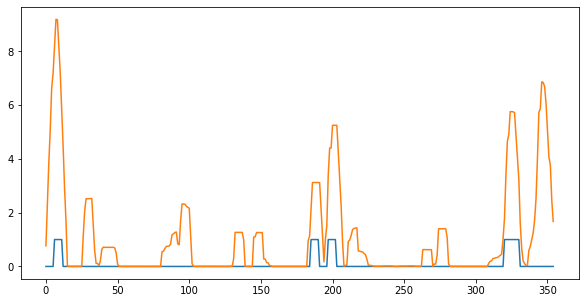

In [ ]:
# Графики распределения предсказаний 

for i in range(10):
  fig = plt.figure(figsize=(10, 5))

  plt.plot(totalTrueVals[i])  
  plt.plot(totalResultCum[i])

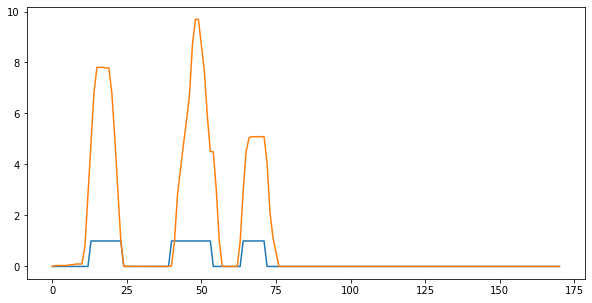

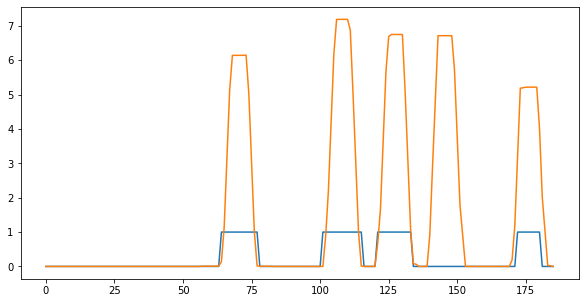

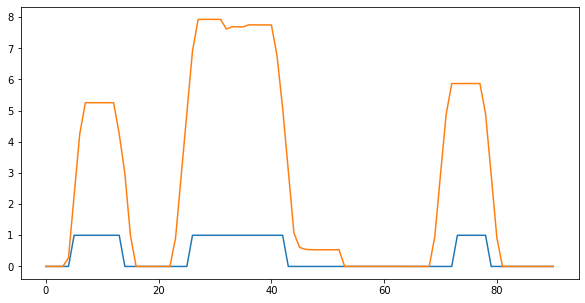

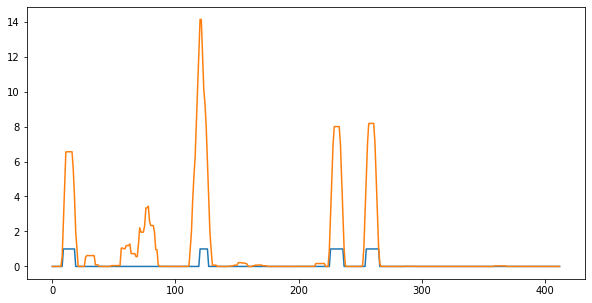

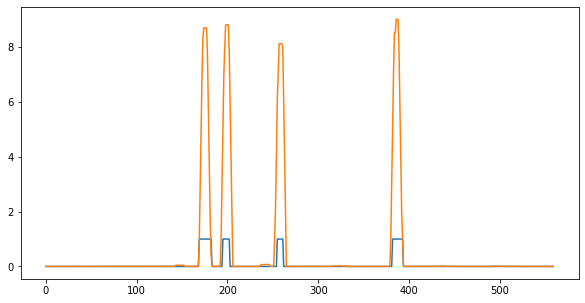

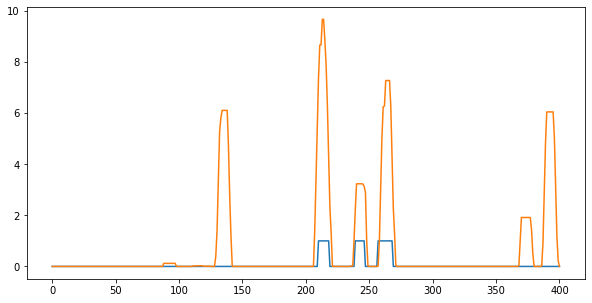

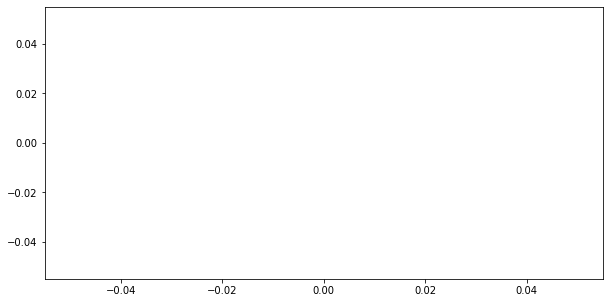

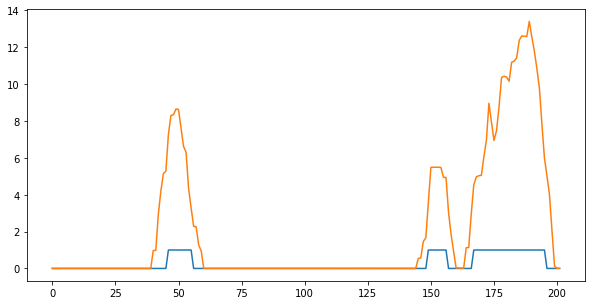

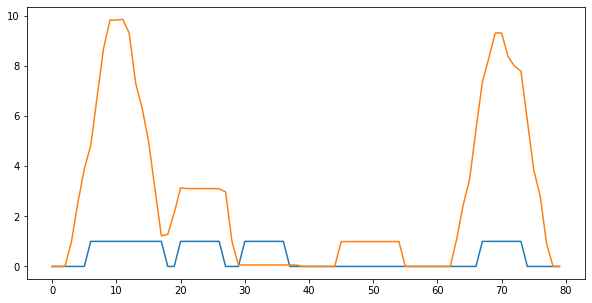

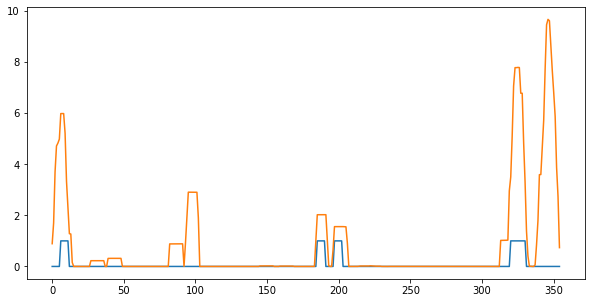

In [ ]:
# window 10 + window 8 # Графики распределения предсказаний 

for i in range(10):
  fig = plt.figure(figsize=(10, 5))

  plt.plot(totalTrueVals[i])  
  plt.plot(totalResultCum[i])